In [1]:
pip install pennylane --upgrade

     |████████████████████████████████| 631 kB 5.3 MB/s 
     |████████████████████████████████| 4.4 MB 43.0 MB/s 


In [2]:
#general import
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

In [3]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

# scaling the inputs 
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

y_scaled = y 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3,random_state=109)

In [4]:
print('Shape X_train:', X_train.shape)
print('Shape Y_train', y_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape Y_test:', y_test.shape)

Shape X_train: (398, 30)
Shape Y_train (398,)
Shape X_test: (171, 30)
Shape Y_test: (171,)


# Hybrid model between classical and quantum hardware!

In [5]:
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [6]:
n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits)}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

clayer_1 = torch.nn.Linear(30,6)
clayer_2 = torch.nn.Linear(6,2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

opt = torch.optim.SGD(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

In [7]:
def Check_acc(X_test, y_test):   
  X_t = torch.tensor(X_test, requires_grad=True).float()
  y_pred = model(X_t)
  predictions = torch.argmax(y_pred, axis=1).detach().numpy()
  #print(predictions)
  correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y_test)]
  accuracy = sum(correct) / len(correct)
  print(f"Accuracy: {accuracy * 100}%")
  return accuracy

X = torch.tensor(X_train, requires_grad=True).float()


batch_size = 5
batches = 398 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_train)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 20
loss_vec = []
acc_vec = []
for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()
        #print(xs)
        #print(model(xs))
        loss_evaluated = loss(model(xs)[:, 1], ys)
        loss_evaluated.backward()
        
        opt.step()
        
        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))
    acc_vec.append(Check_acc(X_test, y_test))
    loss_vec.append(avg_loss)



/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /pytorch/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Average loss over epoch 1: 0.4215
Accuracy: 80.11695906432749%
Average loss over epoch 2: 0.2554
Accuracy: 81.87134502923976%
Average loss over epoch 3: 0.2174
Accuracy: 94.73684210526315%
Average loss over epoch 4: 0.1593
Accuracy: 90.64327485380117%
Average loss over epoch 5: 0.1628
Accuracy: 88.30409356725146%
Average loss over epoch 6: 0.1456
Accuracy: 94.15204678362574%
Average loss over epoch 7: 0.1665
Accuracy: 51.461988304093566%
Average loss over epoch 8: 0.2636
Accuracy: 88.88888888888889%
Average loss over epoch 9: 0.2068
Accuracy: 66.66666666666666%
Average loss over epoch 10: 0.1883
Accuracy: 85.38011695906432%
Average loss over epoch 11: 0.2242
Accuracy: 52.63157894736842%
Average loss over epoch 12: 0.3731
Accuracy: 67.83625730994152%
Average loss over epoch 13: 0.2731
Accuracy: 81.28654970760235%
Average loss over epoch 14: 0.3954
Accuracy: 59.64912280701754%
Average loss over epoch 15: 0.4329
Accuracy: 56.72514619883041%
Average loss over epoch 16: 0.4167
Accuracy: 64.

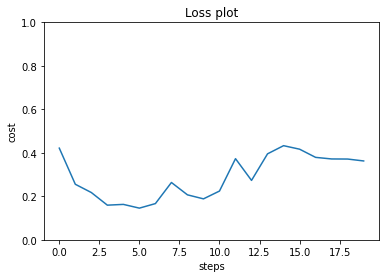

In [8]:
plt.plot(range(20), loss_vec)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.title('Loss plot')
plt.show()